In [1]:
from __future__ import annotations
from typing import Optional, Tuple
import pandas as pd 
from copy import deepcopy
from scipy.stats.contingency import odds_ratio
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools
import seaborn as sns
import numpy as np

**Load data**

In [2]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEER_2010_2020.clean.tsv'
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')

# basic formatting
master = master.loc[master['diagnosis_year'] >= 2010]
master['hist_cateogry'] = master['hist_cateogry'].apply(lambda x: x.split(':')[-1].strip())

In [3]:
# histologic type - mappings available in tsv file
HISTTYPES_PATH = '/home/grace/work/SEER/data/histology/histcodes.tsv'
HISTTYPES_MAP = {}
with open(HISTTYPES_PATH, 'r') as fp:
    line = fp.readline()
    while line:
        code, descr = line.strip('\n').split('\t')
        HISTTYPES_MAP[code] = descr
        line = fp.readline()

seer_codes = list(master['hist_type'].unique())
seer_codes = set([str(x) for x in seer_codes])
known_codes = set(HISTTYPES_MAP.keys())
missing_codes = seer_codes - known_codes
print(f'Missing {len(missing_codes)} codes.')
for code in missing_codes:
    print(code)

# do mapping
def map_histcode_to_descr(code: str) -> str:
    descr = HISTTYPES_MAP[code]
    if '|' in descr:
        descr = descr.split('|')[0] + ' [+ others]'
    return descr

master['hist_type'] = master['hist_type'].apply(str)
master['hist_type_descr'] = master['hist_type'].apply(map_histcode_to_descr)

Missing 0 codes.


In [4]:
singles_df = master.drop_duplicates(subset=['patient_id'], keep=False)
singles_df = singles_df.loc[singles_df['cancer_type'] != 'Brain']
multiples_df = master[master.duplicated(subset=['patient_id'], keep=False)]
master.head()

,patient_id,patient_death_year,diagnosis_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,...,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,distant_ln,hist_type_descr
0,98,NaN,2015,75-79 years,Vulva,Vulva,Vulva,Vulva,Tis,N0,...,NaN,NaN,8542,ductal and lobular neoplasms,False,False,False,False,NaN,Paget disease
1,123,2017.0,2012,85-89 years,Myeloma,Leukemia,Myeloma,Leukemia,NaN,NaN,...,NaN,NaN,9732,plasma cell tumors,NaN,NaN,NaN,NaN,NaN,Plasma cell myeloma
4,124,2011.0,2010,70-74 years,Breast,Breast,Breast,Breast,T3,N0,...,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,False,False,False,False,NaN,Infiltrating duct carcinoma [+ others]
5,125,NaN,2018,70-74 years,Breast,Breast,Breast,Breast,T2,N0,...,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,False,False,False,False,False,Infiltrating duct carcinoma [+ others]
6,179,NaN,2016,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,...,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",False,False,False,False,False,Serous carcinoma [+ others]


**Addressing tumors where 'site recode' is mismatch to 'primary site'**

For patients with single record, these only occur when 'site recode' is a cancer_type of nebulous location. <br>
Specifically, Lymphomas. 

Necessary because SEER 'site recode' and 'primary site' mean different things. 

site recode (cancer_type)
- cancer type rather than 'site' (eg Hodgkin Lymphoma)

primary site (primary_type)
- location of primary tumor. 
- organ (eg lung), or region (eg Bones and Joints) 
- in the case of Hodgkin Lymphoma etc, primary site could be any general location as lymph nodes are spread around the body. 
    

In [5]:
def override_primary_types(df: pd.DataFrame) -> pd.DataFrame:
    # if unsure between melanoma & non-melanoma, non-melanoma more common so guess this label.
    df.loc[df['primary_type']=='Melanoma of the Skin | Other Non-Epithelial Skin', 'primary_type'] = 'Other Non-Epithelial Skin'

    # override primary_type for cancer_types where the primary tumor can appear in variable locations in the body. 
    for ctype in [
        'NHL - Extranodal',
        'Mesothelioma',
        'Kaposi Sarcoma',
        'Myeloma',
        'Hodgkin - Extranodal',
        'Other Myeloid/Monocytic Leukemia',
    ]:
        # print()
        # print(df.loc[(df['cancer_type']!=df['primary_type']) & (df['cancer_type']==ctype)].head())
        # print()
        df.loc[(df['cancer_type']!=df['primary_type']) & (df['cancer_type']==ctype), 'primary_type'] = ctype
    return df

def summarise_mismatches(df: pd.DataFrame) -> None:
    mm_df = df[df['cancer_type'] != df['primary_type']][['cancer_type', 'primary_type']]
    mm_df['mismatches'] = mm_df['cancer_type'] + ' | ' + mm_df['primary_type']
    print(f'\nTotal mismatches: {mm_df.shape[0]}')
    print(mm_df['mismatches'].value_counts().head(10))

summarise_mismatches(singles_df)
singles_df = override_primary_types(singles_df)
summarise_mismatches(singles_df)



Total mismatches: 61816
mismatches
NHL - Extranodal | Melanoma of the Skin | Other Non-Epithelial Skin    11665
Mesothelioma | Pleura                                                   6144
NHL - Extranodal | Stomach                                              5661
NHL - Extranodal | Brain | Cranial Nerves Other Nervous System          3395
Kaposi Sarcoma | Melanoma of the Skin | Other Non-Epithelial Skin       3043
NHL - Extranodal | Small Intestine                                      2902
NHL - Extranodal | Lung and Bronchus                                    2098
NHL - Extranodal | Eye and Orbit                                        1940
NHL - Extranodal | Soft Tissue including Heart                          1815
Myeloma | Bones and Joints                                              1642
Name: count, dtype: int64

Total mismatches: 0
Series([], Name: count, dtype: int64)


Propensity 

In [6]:
# def bool_to_yes_no(df: pd.DataFrame, fields: list[str]) -> pd.DataFrame:
#     for field in fields:
#         df[field] = df[field].apply(lambda x: 'YES' if x else 'NO')
#     return df 

# new dataframe
predictor_fields = [
    'cancer_type', 'cancer_group', 'primary_type', 'primary_group', 
    'hist_type_descr', 'hist_cateogry', 'breast_subtype'
]
response_fields = ['brain_met', 'bone_met', 'lung_met', 'liver_met']
met_df = singles_df[['patient_id'] + predictor_fields + response_fields]

# TODO: test dropping NA?  
# ie patient brain_met = False, vs brain_met = NA
# for now, just assign NA -> False
for res_feat in response_fields:
    met_df.loc[~met_df[res_feat].notna(), res_feat] = False
met_df['any_met'] = met_df[response_fields].any(axis=1)


In [12]:

BRAIN_PREFERENCE_MEASURE = 'p( BRAIN MET | ANY MET )'
# BRAIN_PREFERENCE_MEASURE = 'BRAIN PREFERENCE MEASURE'

def calculate_met_rates(pred: str, responses: list[str], df: pd.DataFrame) -> Tuple:
    # df for raw case counts
    counts = pd.DataFrame()
    for res in responses:
        yn_df = df.groupby(by=[pred, res]).size().unstack(fill_value=0)
        counts[res + '_NO'] = yn_df[False]
        counts[res + '_YES'] = yn_df[True]
    yn_df = df.groupby(by=[pred, 'any_met']).size().unstack(fill_value=0)
    counts['ANY_NO'] = yn_df[False]
    counts['ANY_YES'] = yn_df[True]

    # df for prevalence
    prevs = pd.DataFrame()
    for res in responses + ['ANY']:
        prevs[res] = counts[res + '_YES'] / (counts[res + '_NO'] + counts[res + '_YES'])
    
    return counts, prevs

def run_met_rates(
    df: pd.DataFrame,
    predictors: list[str], 
    responses: list[str],
    subsets: Optional[dict]=None,
    min_observations: int=1000
    ) -> pd.DataFrame:
    if subsets:
        for field, vlist in subsets.items():
            df = df.loc[df[field].isin(vlist)]
        
    if len(predictors) == 0:
        raise ValueError
    elif len(predictors) == 1:
        pred = predictors[0]
    else:
        # TODO in development, weird behaviour
        print(f'\n Predictors: {predictors}')
        print(f'Before NAdrop: {df.shape[0]}')
        df = df.dropna(subset=predictors, thresh=1)
        print(f'After NAdrop: {df.shape[0]}')
        pred = ': '.join(predictors)
        for item in predictors:
            df[item] = df[item].apply(str)
        df[pred] = df[predictors].agg(': '.join, axis=1)
    
    # filter out categories with low number of observations 
    feature_values1 = set(df[pred].unique())
    df = df.groupby(pred).filter(lambda x : len(x) >= min_observations)
    feature_values2 = set(df[pred].unique())
    filtered_values = feature_values1 - feature_values2
    # print(f'Removed the following categories with low observations:')
    # for val in list(filtered_values):
    #     print(val)

    counts, prevs = calculate_met_rates(pred, responses, df)
    # print(counts.head())

    summ = pd.DataFrame()
    summ['NUM RECORDS'] = counts['ANY_NO'] + counts['ANY_YES']
    summ['BRAIN (%)'] = prevs['brain_met'] * 100
    summ['BONE (%)'] = prevs['bone_met'] * 100
    summ['LUNG (%)'] = prevs['lung_met'] * 100
    summ['LIVER (%)'] = prevs['liver_met'] * 100
    summ['ANY (%)'] = prevs['ANY'] * 100
    
    # temp = counts[['bone_met_YES', 'lung_met', 'liver_met']].head()
    # temp = temp.max(axis=0) / (counts['brain_met_YES'].head())
    
    # summ[BRAIN_PREFERENCE_MEASURE] = counts[['bone_met_YES', 'lung_met', 'liver_met']].max(axis=0) / (counts['brain_met_YES'])
    summ[BRAIN_PREFERENCE_MEASURE] = counts['brain_met_YES'] / (counts['ANY_YES'])

    # print(temp)

    print(summ.shape)
    return summ
    # plot_met_rates(summ, title=f'{pred} vs Metastasis')


In [8]:

def plot_met_rates(df: pd.DataFrame, sortcol: str, title: str) -> None:
    MAX_ROWS = 12
    df = df.sort_values(by=sortcol, ascending=False)
    if df.shape[0] < MAX_ROWS:
        rowcount = df.shape[0]
        _plot_met_rates_unified(df, title, rowcount)
    else:
        rowcount = min(df.shape[0]//2, MAX_ROWS)
        _plot_met_rates_split(df, title, rowcount)

def _plot_met_rates_unified(df: pd.DataFrame, title: str, rowcount: int) -> None:

    LARGE_VALUE = 100000000000000
    pd.set_option('display.max_rows', 50)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 150)
    pd.options.display.float_format = "{:,.2f}".format
    
    freqs_top = df.drop(['NUM RECORDS', BRAIN_PREFERENCE_MEASURE], axis=1)
    cases1D_top = df[['NUM RECORDS']]
    tend1D_top = df[[BRAIN_PREFERENCE_MEASURE]]
    
    # fig, axs = plt.subplots(1,3,gridspec_kw={'width_ratios':[5,1,1]})
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, (rowcount//2)+4), gridspec_kw={'width_ratios':[5,1,1]}, layout="compressed")
    a1 = axs[0].matshow(freqs_top, cmap='rocket_r', vmax=80)
    axs[1].matshow(tend1D_top, cmap='PiYG_r', vmin=-0.3, vmax=0.4)
    axs[2].matshow(cases1D_top, cmap='binary', vmax=LARGE_VALUE)

    flat_axes = axs.flat
    flat_data = [freqs_top, tend1D_top, cases1D_top]
    for i, (ax, data) in enumerate(zip(flat_axes, flat_data)):
        data_matrix = data.T.to_numpy()
        # render actual values in cells
        # if i % 3 == 0:
        #     data_matrix = data.T.to_numpy()
        # else:
        #     data_matrix = np.expand_dims(data.T.to_numpy(), axis=1)
        for (x, y), value in np.ndenumerate(data_matrix):
            if i % 3 == 2:
                ax.text(x-0.5, y, f"{value}", va="center", ha="left")
            elif i % 3 == 1:
                ax.text(x, y, f"{value:.2f}", va="center", ha="center")
            else:
                ax.text(x, y, f"{value:.1f}", va="center", ha="center")
        
        # first col: add y ticks
        if i % 3 == 0:
            ytick_marks = np.arange(len(data.index))
            ax.set_yticks(ytick_marks, data.index)
            # ax.set_ylabel(data.index.name)
        else:
            ax.set_yticks([])
        
        # first row: add x ticks
        xtick_marks = np.arange(len(data.columns))
        ax.set_xticks(xtick_marks, data.columns, rotation=90)

        # third row: remove frame 
        if i % 3 == 2:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.tick_params(left = False, top = False, bottom = False)
    
    plt.suptitle(title, y=1.03, fontsize='x-large')
    title_fmtd = title.strip()
    title_fmtd = title_fmtd.split(' vs ')[0]
    title_fmtd = title_fmtd.replace('_', '')
    title_fmtd = title_fmtd.replace(': ', '_')
    title_fmtd = title_fmtd.lower()
    filename = f'/home/grace/work/SEER/outputs/heatmaps/{title_fmtd}.png'
    plt.savefig(filename)


def _plot_met_rates_split(df: pd.DataFrame, title: str, rowcount: int) -> None:

    LARGE_VALUE = 100000000000000
    pd.set_option('display.max_rows', 50)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 150)
    pd.options.display.float_format = "{:,.2f}".format
    
    freqs_top = df.drop(['NUM RECORDS', BRAIN_PREFERENCE_MEASURE], axis=1).head(rowcount)
    freqs_bot = df.drop(['NUM RECORDS', BRAIN_PREFERENCE_MEASURE], axis=1).tail(rowcount)
    cases1D_top = df[['NUM RECORDS']].head(rowcount)
    cases1D_bot = df[['NUM RECORDS']].tail(rowcount)
    tend1D_top = df[[BRAIN_PREFERENCE_MEASURE]].head(rowcount)
    tend1D_bot = df[[BRAIN_PREFERENCE_MEASURE]].tail(rowcount)
    
    # fig, axs = plt.subplots(1,3,gridspec_kw={'width_ratios':[5,1,1]})
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, rowcount+4), gridspec_kw={'width_ratios':[5,1,1]}, layout="compressed")
    a1 = axs[0, 0].matshow(freqs_top, cmap='rocket_r', vmax=80)
    axs[0, 1].matshow(tend1D_top, cmap='PiYG_r', vmin=-0.3, vmax=0.4)
    axs[0, 2].matshow(cases1D_top, cmap='binary', vmax=LARGE_VALUE)
    axs[1, 0].matshow(freqs_bot, cmap='rocket_r', vmax=80)
    axs[1, 1].matshow(tend1D_bot, cmap='PiYG_r', vmin=-0.3, vmax=0.4)
    axs[1, 2].matshow(cases1D_bot, cmap='binary', vmax=LARGE_VALUE)

    flat_axes = axs.flat
    flat_data = [freqs_top, tend1D_top, cases1D_top, freqs_bot, tend1D_bot, cases1D_bot]
    for i, (ax, data) in enumerate(zip(flat_axes, flat_data)):
        data_matrix = data.T.to_numpy()
        # render actual values in cells
        # if i % 3 == 0:
        #     data_matrix = data.T.to_numpy()
        # else:
        #     data_matrix = np.expand_dims(data.T.to_numpy(), axis=1)
        for (x, y), value in np.ndenumerate(data_matrix):
            if i % 3 == 2:
                ax.text(x-0.5, y, f"{value}", va="center", ha="left")
            elif i % 3 == 1:
                ax.text(x, y, f"{value:.2f}", va="center", ha="center")
            else:
                ax.text(x, y, f"{value:.1f}", va="center", ha="center")
        
        # first col: add y ticks
        if i % 3 == 0:
            ytick_marks = np.arange(len(data.index))
            ax.set_yticks(ytick_marks, data.index)
            # ax.set_ylabel(data.index.name)
        else:
            ax.set_yticks([])
        
        # first row: add x ticks
        if i < 3:
            xtick_marks = np.arange(len(data.columns))
            ax.set_xticks(xtick_marks, data.columns, rotation=90)
        else:
            ax.set_xticks([])

        # third row: remove frame 
        if i % 3 == 2:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)

        if i == 0:
            ax.set_title(f'Top {rowcount}', y=1.15)
        if i == 3:
            ax.set_title(f'Bottom {rowcount}')
        ax.tick_params(left = False, top = False, bottom = False)
    
    plt.suptitle(title, y=1.03, fontsize='x-large')
    title_fmtd = title.strip()
    title_fmtd = title_fmtd.split(' vs ')[0]
    title_fmtd = title_fmtd.replace('_', '')
    title_fmtd = title_fmtd.replace(': ', '_')
    title_fmtd = title_fmtd.lower()
    filename = f'/home/grace/work/SEER/outputs/heatmaps/{title_fmtd}.png'
    plt.savefig(filename)




(50, 7)


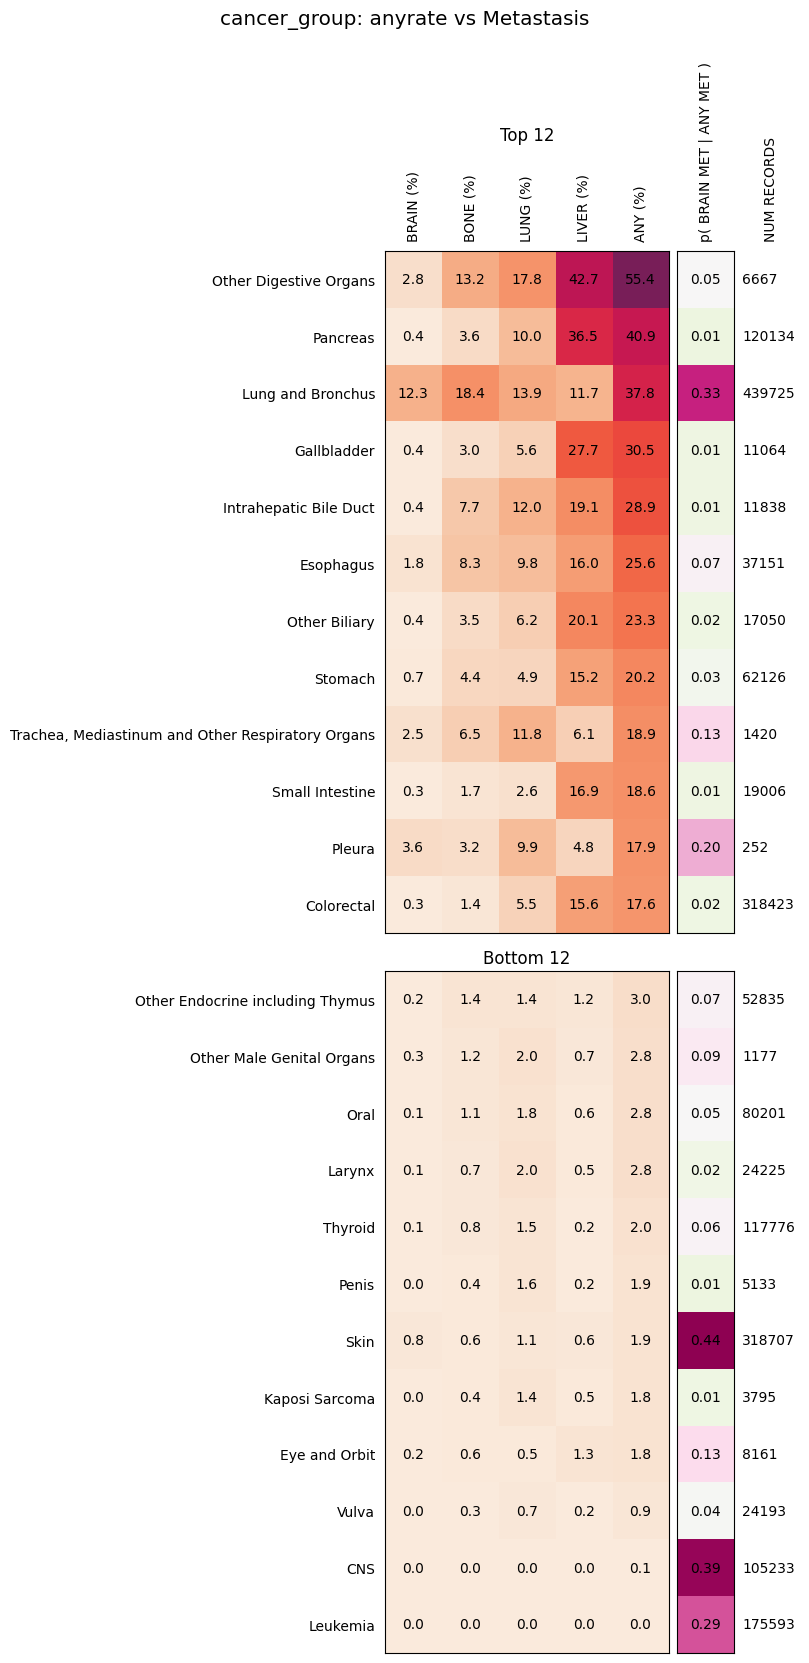

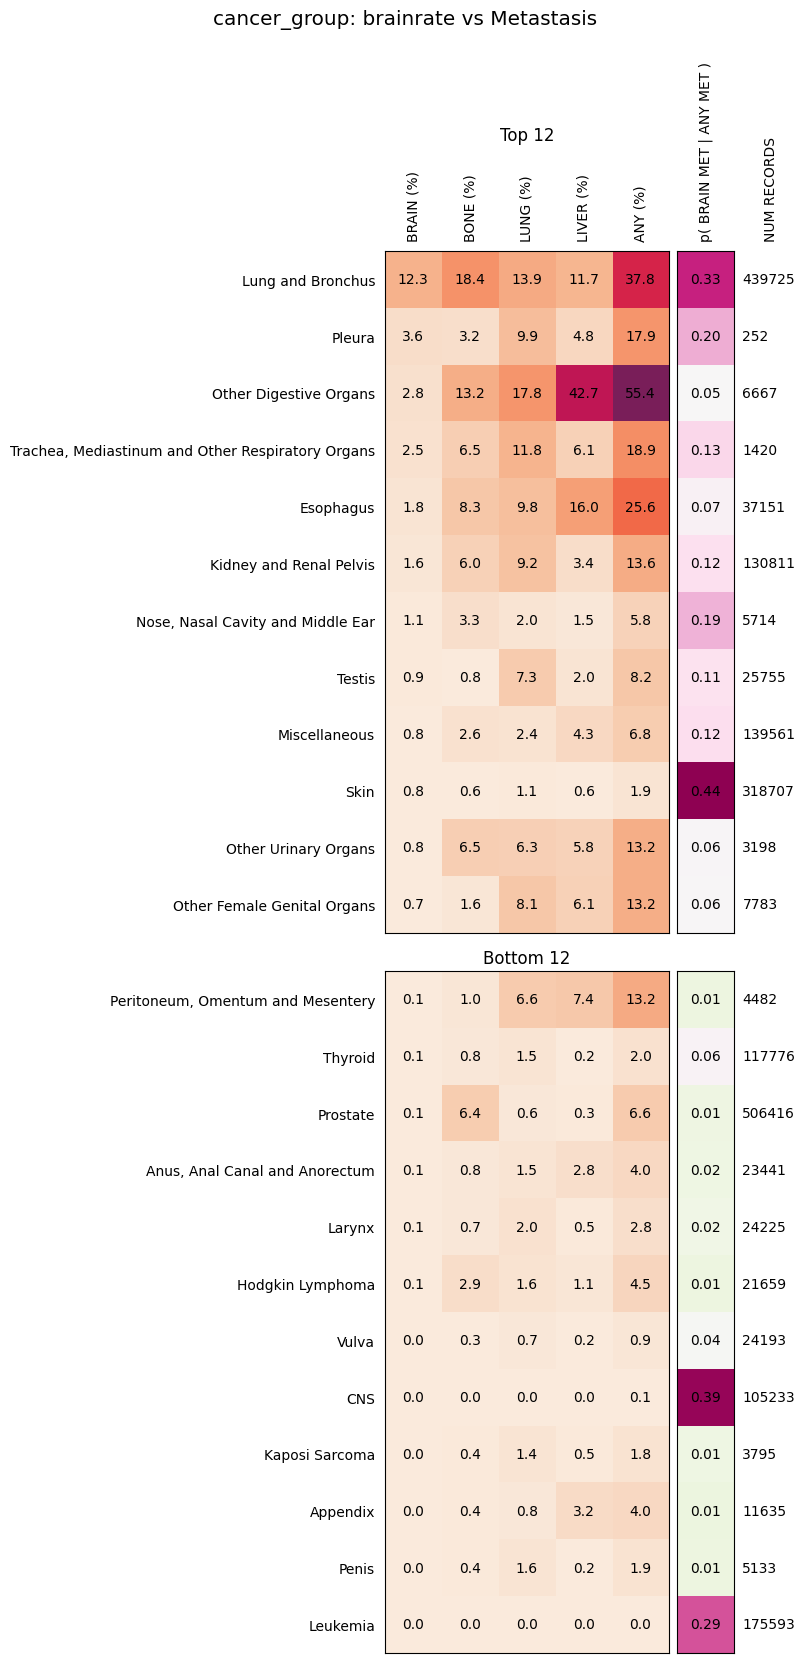

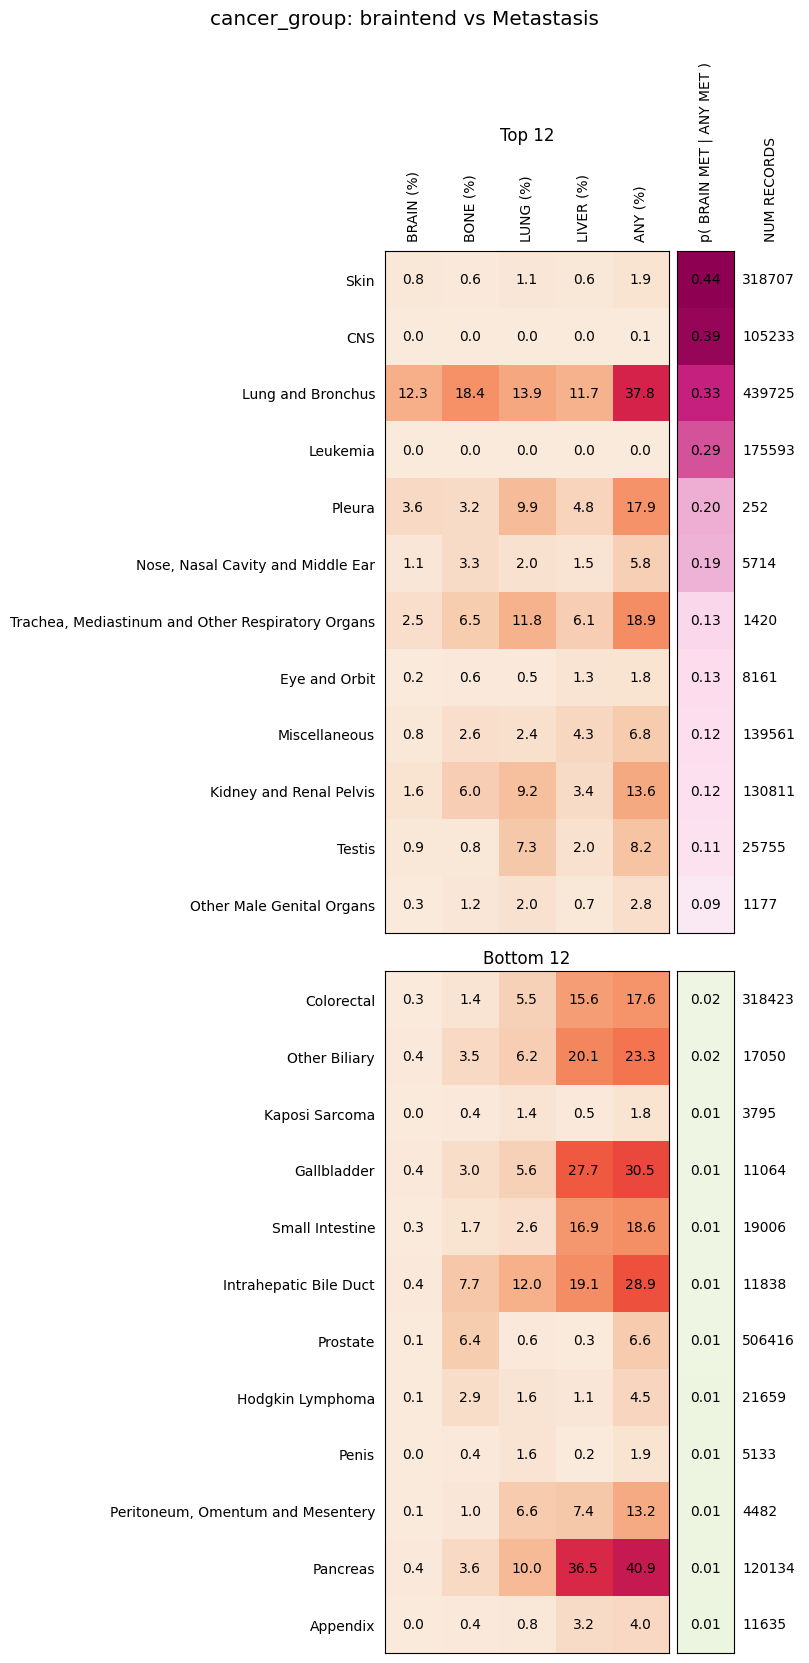

In [13]:
MIN_FEATURE_OBSERVATIONS = 50
# features = ['cancer_type']
# subsets = {'cancer_type': ['Breast']}
# extra_label = ': breast'

# features = ['cancer_group']
# features = ['hist_cateogry']
# features = ['cancer_group', 'hist_cateogry']
# subsets = None

# features = ['cancer_type', 'hist_cateogry']
# features = ['cancer_group', 'hist_type_descr']
features = ['cancer_group']
subsets = None
extra_label = ''
summ = run_met_rates(
    df=met_df, 
    predictors=features, 
    responses=response_fields, 
    subsets=subsets,
    min_observations=MIN_FEATURE_OBSERVATIONS
)
plot_met_rates(summ, sortcol='ANY (%)', title=f'{": ".join(features)}{extra_label}: anyrate vs Metastasis')
plot_met_rates(summ, sortcol='BRAIN (%)', title=f'{": ".join(features)}{extra_label}: brainrate vs Metastasis')
plot_met_rates(summ, sortcol=BRAIN_PREFERENCE_MEASURE, title=f'{": ".join(features)}{extra_label}: braintend vs Metastasis')

In [18]:
summ.head()
sorted(list(summ.index))
# summ['Peritoneum, Omentum and Mesentery'].head()

KeyError: 'Peritoneum, Omentum and Mesentery'

In [ ]:
plot_met_rates(summ, sortcol=BRAIN_PREFERENCE_MEASURE, title=f'{": ".join(features)} vs Metastasis')

aslkdj
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [ ]:
singles_df = master.drop_duplicates(subset=['patient_id'], keep=False)
multiples_df = master[master.duplicated(subset=['patient_id'], keep=False)]

In [ ]:
singles_df = master.drop_duplicates(subset=['patient_id'], keep=False)
multiples_df = master[master.duplicated(subset=['patient_id'], keep=False)]

In [ ]:
mismatch_pids = master[master['cancer_type'] != master['primary_type']]['patient_id']
mismatch_pids = set(mismatch_pids.to_list())
mismatch_df = master[master['patient_id'].isin(mismatch_pids)][['patient_id', 'diagnosis_year', 'cancer_type', 'primary_type', 'primary_group']]

# separate to patients with single record vs multiple records
mm_singles_df = mismatch_df.drop_duplicates(subset=['patient_id'], keep=False)
mm_multiples_df = mismatch_df[mismatch_df.duplicated(subset=['patient_id'], keep=False)]


In [ ]:
# fix primary_type labels for patients with multiple tumors. 

# example 1 ---
# idx   diagnosis_year  patient_id	    cancer_type	            primary_type
# 1     2013            3226	        Melanoma of the Skin	Melanoma of the Skin
# 2     2015            3226	        NHL - Extranodal	    Melanoma of the Skin | Other Non-Epithelial Skin
# 3     2018            3226	        Melanoma of the Skin	Melanoma of the Skin
# ^ idx==2 change primary_type to 'Melanoma of the Skin' 

# example 2 ---
# idx   diagnosis_year  patient_id	    cancer_type	            primary_type
# 1     2011            9833	        Myeloma	                Bones and Joints
# 2     2011            9833	        Myeloma	                Myeloma
# ^ idx==1 change primary_type to 'Myeloma' 

def select_primary_fields(tumors: list[Tuple]) -> Tuple[str | None, str | None]:
    selected_ptype = None
    selected_pgroup = None
    
    min_year = min(t[0] for t in tumors)
    minyear_types = set([t[2] for t in tumors if t[0] == min_year])
    agreement_types = set([t[2] for t in tumors if t[1] == t[2]])
    intersection_types = minyear_types & agreement_types 
    unique_types = set([t[2] for t in tumors])

    # single tumor at first contact, and the cancer_type matches the primary_type
    if len(intersection_types) == 1:
        selected_ptype = intersection_types.pop()
    
    elif len(unique_types) == 1:
        selected_ptype = unique_types.pop()
    
    if selected_ptype:
        selected_pgroup = [t[3] for t in tumors if selected_ptype in t[2]][0]
        return selected_ptype, selected_pgroup
 
    return None, None

def update_primary_fields(pid: str, ptype: str, pgroup: str, df: pd.DataFrame) -> None:
    mm_df = df[df['patient_id'] == pid]
    mm_df = mm_df[mm_df['primary_type'] != ptype]

    for idx, row in mm_df.iterrows():
        # example 2 idx 1
        if row['cancer_type'] == ptype:
            df.loc[idx, 'primary_type'] = ptype
            df.loc[idx, 'primary_group'] = pgroup
            assert df.loc[idx]['primary_type'] == ptype
            assert df.loc[idx]['primary_group'] == pgroup
        # example 1 idx 2
        # '|' situation
        elif ptype in row['primary_type']:
            df.loc[idx, 'primary_type'] = ptype
            df.loc[idx, 'primary_group'] = pgroup
            assert df.loc[idx]['primary_type'] == ptype
            assert df.loc[idx]['primary_group'] == pgroup
        else:
            continue 

pids = mm_multiples_df['patient_id'].unique()
print(f'PIDs to process: {len(pids)}')
for i, pid in enumerate(pids):
    # subset dataframe to just this patient
    pid_df = mm_multiples_df[mm_multiples_df['patient_id'] == pid]
    records = pid_df[['diagnosis_year', 'cancer_type', 'primary_type', 'primary_group']].to_records(index=False).tolist()
    ptype, pgroup = select_primary_fields(records)
    if ptype and pgroup:
        update_primary_fields(pid, ptype, pgroup, master)
    if i % 1000 == 0:
        print(f'processed {i} pids.')


In [ ]:

# # single mismatches are common for cancer_type of widespread region. eg lymphomas / leukemia. 
# # this is because site and primary_site mean different things in SEER. 
# combinations = pd.DataFrame()
# combinations['cancer_type'] = mm_singles_df['cancer_type']
# combinations['primary_type'] = mm_singles_df['primary_type']
# combinations['cancer_type && primary_type'] = combinations['cancer_type'] + ' && ' + combinations['primary_type']

# """
# NHL - Extranodal                    47750
# Mesothelioma                         7491
# Kaposi Sarcoma                       3755
# Myeloma                              2262
# Hodgkin - Extranodal                  331
# Other Myeloid/Monocytic Leukemia      227
# """
# print(combinations['cancer_type'].value_counts())
# print('\nNHL - Extranodal ---')
# print(combinations[combinations['cancer_type'] == 'NHL - Extranodal']['primary_type'].value_counts().head(10))
# print('\nMesothelioma ---')
# print(combinations[combinations['cancer_type'] == 'Mesothelioma']['primary_type'].value_counts().head(10))
# print('\nKaposi Sarcoma ---')
# print(combinations[combinations['cancer_type'] == 'Kaposi Sarcoma']['primary_type'].value_counts().head(10))
# print('\nMyeloma ---')
# print(combinations[combinations['cancer_type'] == 'Myeloma']['primary_type'].value_counts().head(10))
# print('\n')


In [ ]:
# fix primary_type labels for special cases. 

# example 1 ---
# idx   diagnosis_year  patient_id	    cancer_type	            primary_type
# 1     2013            3226	        Melanoma of the Skin	Melanoma of the Skin
# 2     2015            3226	        NHL - Extranodal	    Melanoma of the Skin | Other Non-Epithelial Skin
# 3     2018            3226	        Melanoma of the Skin	Melanoma of the Skin
# ^ idx==2 change primary_type to 'Melanoma of the Skin' 

# example 2 ---
# idx   diagnosis_year  patient_id	    cancer_type	            primary_type
# 1     2011            9833	        Myeloma	                Bones and Joints
# 2     2011            9833	        Myeloma	                Myeloma
# ^ idx==1 change primary_type to 'Myeloma' 

mismatch_pids = master[master['cancer_type'] != master['primary_type']]['patient_id']
mismatch_pids = set(mismatch_pids.to_list())
mismatch_df = master[master['patient_id'].isin(mismatch_pids)][['patient_id', 'diagnosis_year', 'cancer_type', 'primary_type', 'primary_group', 'hist_cateogry']]

# separate to patients with single record vs multiple records
mm_singles_df = mismatch_df.drop_duplicates(subset=['patient_id'], keep=False)
mm_multiples_df = mismatch_df[mismatch_df.duplicated(subset=['patient_id'], keep=False)]
temp = mm_multiples_df.head()

for pid in temp['patient_id'].unique():
    sel_ptype = None
    sel_pgroup = None
    
    # subset dataframe to just this patient
    pid_df = temp[temp['patient_id'] == pid]
    
    # get rows relating to tumors at earliest timepoint
    pid_init_df = pid_df[pid_df['diagnosis_year']==pid_df['diagnosis_year'].min()]
    if pid_init_df.shape[0] == 1:
        sel_ptype = pid_init_df.iloc[0]['primary_type']
        sel_pgroup = pid_init_df.iloc[0]['primary_group']

    # check if any agreement between cancer_type and primary_type
    # example 1, idx 1 above is agreement. 
    # example 2, idx 1 above is disagreement. 
    # example 2, idx 2 above is agreement. 
    pid_agree_df = pid_init_df[pid_init_df['cancer_type'] == pid_init_df['primary_type']]
    if pid_agree_df.shape[0] >= 1:
        sel_ptype = pid_init_df.iloc[0]['primary_type']
        sel_pgroup = pid_init_df.iloc[0]['primary_group']

    assert sel_ptype
    assert sel_pgroup
    # get rows with mismatches
    pid_mm_df = pid_df[pid_df['cancer_type'] != pid_df['primary_type']]
    # print(pid_mm_df)
    # do fixes
    for idx, row in pid_mm_df.iterrows():
        # print(idx)
        update_success = False

        # example 2 idx 1 scenario fix
        old_ptype = row['primary_type']
        if row['cancer_type'] == sel_ptype:
            # print(temp)
            temp.loc[idx]['primary_type'] = sel_ptype
            temp.loc[idx]['primary_group'] = sel_pgroup
            # print(temp)
            update_success = True
        # example 1 idx 2 scenario fix
        elif '|' in old_ptype:
            options = old_ptype.split('|')
            for opt in options:
                if opt.strip() == sel_ptype:
                    print(temp)
                    temp.loc[idx]['primary_type'] = sel_ptype
                    temp.loc[idx]['primary_group'] = sel_pgroup
                    update_success = True
                    break
        if not update_success:
            print(temp)
            print(sel_ptype)
            print(sel_pgroup)
            print(temp)
            raise RuntimeError

    # does this work? 
    # print(temp[temp['patient_id'] == pid])
    break 
    


# # single mismatches are odd
# combinations = pd.DataFrame()
# combinations['cancer_type'] = mm_singles_df['cancer_type']
# combinations['primary_type'] = mm_singles_df['primary_type']
# combinations['cancer_type && primary_type'] = combinations['cancer_type'] + ' && ' + combinations['primary_type']
# """
# NHL - Extranodal                    47750
# Mesothelioma                         7491
# Kaposi Sarcoma                       3755
# Myeloma                              2262
# Hodgkin - Extranodal                  331
# Other Myeloid/Monocytic Leukemia      227
# """

# # print(combinations['cancer_type'].value_counts().head(20))
# print(combinations[combinations['cancer_type'] == 'NHL - Extranodal']['primary_type'].value_counts().head(20))
